# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [1]:
%matplotlib inline
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
import batman
from lightkurve.lightcurve import LightCurve
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler

First we need to read in the photometry data. This notebook assumes that photometry has been performed with [AstroImageJ](https://www.astro.louisville.edu/software/astroimagej/) and a table of measurements has been saved as a .csv file. In this example, I also pull the preliminary planet and star parameters from a table that I created, but you can insert your parameters however you wish.

In [30]:
data = pandas.read_csv('Data/TESS/TIC_181804752_02_11pxap.csv')
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

In [3]:
TIC_ID = []
names = params['TIC ID']
for i in range(len(names)):
    TIC_ID.append(int(names[i]))

In [4]:
print(str(names))

0     2.345236e+08
1     4.101536e+08
2     3.072108e+08
3     3.072108e+08
4     3.072108e+08
5     3.209058e+07
6     2.625304e+08
7     1.209167e+08
8     2.187958e+08
9     5.565059e+07
10    2.720862e+08
11    2.066096e+08
12    2.760710e+06
13    4.473760e+07
14    1.708495e+08
15    1.242382e+07
16    1.447009e+08
17    1.585890e+08
18    2.204796e+08
19    3.485384e+08
20    3.487557e+08
21    3.189375e+08
22    2.764985e+07
23    2.593770e+08
24    2.593770e+08
25    2.593770e+08
26    2.967399e+08
27    3.500990e+07
28    8.925680e+07
29    9.804616e+06
          ...     
46    1.415276e+08
47    2.600043e+08
48    1.242186e+07
49    1.190811e+08
50    1.497882e+08
51    2.191950e+08
52    2.191950e+08
53    2.752487e+08
54    1.530655e+08
55    2.005940e+08
56    1.504281e+08
57    1.412271e+08
58    2.599621e+08
59    4.159699e+08
60    3.406886e+07
61    3.592711e+08
62    3.672409e+07
63    3.656393e+08
64    3.876905e+08
65    3.050481e+08
66    9.879634e+07
67    2.7197

In [5]:
index = int(73)
planet_name = TIC_ID[index]
observatory = 'LCO 1-m'
print(planet_name)

181804752


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

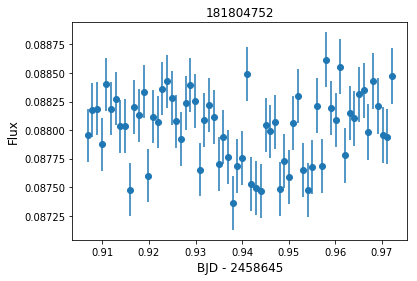

In [31]:
flux = data['rel_flux_T1']
error = data['rel_flux_err_T1']
BJD = data['BJD-OBS']

times = np.array(BJD)

offset = int(times[0])
times = times-offset # This is just a constant offset to make the x-axis more readable

plt.title(planet_name)
plt.errorbar(times,flux,yerr=error,fmt='o')
plt.xlabel('BJD - '+str(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.show()

Polynomial parameters: [0.08630625 0.00196903]


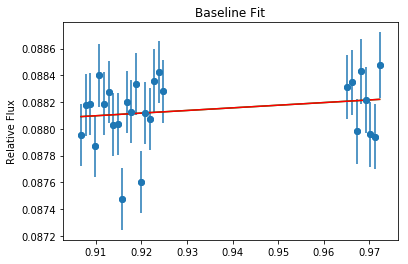

In [32]:
low = 0.925
high = 0.965
mask = np.where(np.logical_not((times >= low)& (times <= high)))[0]

def f_x(x,a,b):
    return a + b*x

popt, pcov = curve_fit(f_x,times[mask],flux[mask])

print("Polynomial parameters:",popt)

poly = f_x(times[mask], *popt)

baseline_fit = f_x(times, *popt)

plt.plot(times[mask],poly,color='green',label='Power-Law')
plt.plot(times,baseline_fit,color='red')
plt.scatter(times[mask],flux[mask])
plt.errorbar(times[mask],flux[mask],yerr=error[mask],fmt='o')
plt.title('Baseline Fit')
plt.ylabel('Relative Flux')
plt.show()

Now let's turn this into a **lightkurve** object

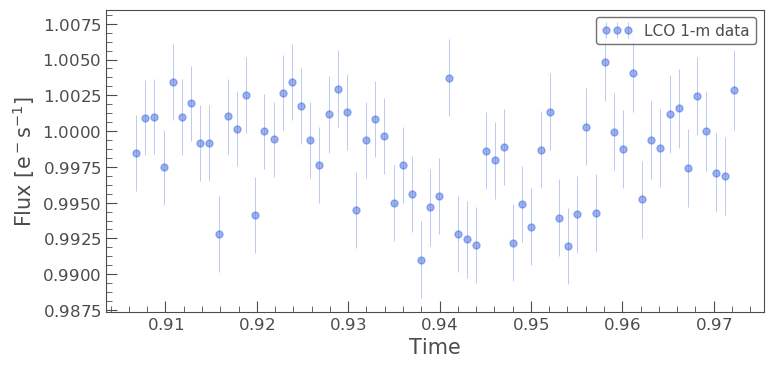

In [33]:
lc = LightCurve(time = times, flux = flux/baseline_fit, flux_err = error/baseline_fit)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [45]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
epoch = params['Epoch'][index] + 2457000.0
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur (hr)'][index] #hours
ppm_depth = params['Depth (ppm)'][index] #ppm
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['log_g'][index] # log g
star_radius = params['R_sun'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset

for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]):
        if (mid_transit_times[i] <= lc.time[-1]):
            
            expected_t0 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0))
            print("Anticipated depth = {:.4f}".format(depth))
            
rp_range = [0,planet_radius*2.0] # The range for a random first guess at Rp/R*
t0_range = [expected_t0-0.05,expected_t0+0.05] # Same, for the time of mid-transit

Anticipated mid-transit time = 0.938936
Anticipated depth = 0.9954


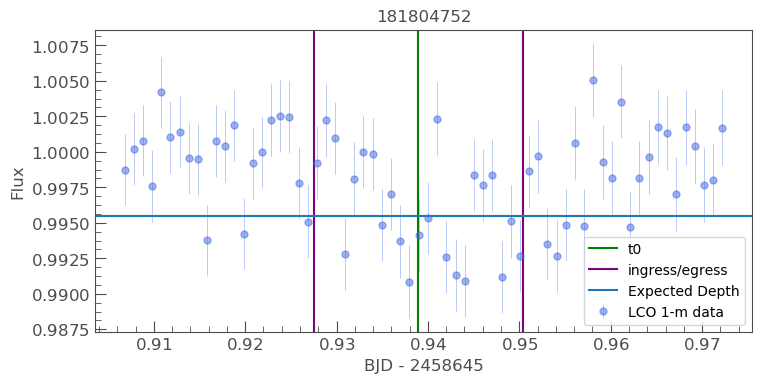

In [10]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title(planet_name)
plt.xlabel('BJD - '+str(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.axhline(depth,label='Expected Depth')
plt.legend()
plt.savefig('{}_NoFit.png'.format(planet_name))
plt.show()

Next, we will define some functions. First is a function that will calculate limb darkening coefficients using [LDTK](https://arxiv.org/abs/1508.02634):

In [11]:
def Limb_Dark(Teff=star_teff,Terr=100,log_g=star_g,g_err=0.1,met=star_met,met_err=0.01):
    
    filters = [kepler]

    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err])
    
    ps = sc.create_profiles(nsamples=500)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    LD_coeff = qc
    
    return LD_coeff

Let's calculate the LDTK coefficients right now to save ourselves computation time when we run the batman model. 

In [12]:
LD_coeff = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
LD = [LD_coeff[0][0],LD_coeff[0][1]]

Need to download 5 files, approximately 80 MB


LDTk downloading uncached files: 100%|██████████| 5/5 [02:14<00:00, 27.42s/it]


Now, we define our [batman](https://astro.uchicago.edu/~kreidberg/batman/) transit model function:

In [13]:
def BATMAN(Baseline = 1.0, # units are whatever your flux units come in
           Rp = planet_radius,
           P = planet_period,
           a = planet_a,
           b = planet_b,
           t0 = expected_t0,
           t = None):
            
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = a                         # semi-major axis (in units of stellar radii)
    params.inc = np.arccos(b/a)*180/np.pi   # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

Now, before we begin MCMC modeling, let's plot the data with a model based on the reported parameters - this way we can make sure some of our functions are running properly and do a visual confirmation that the reported parameters are accurate.

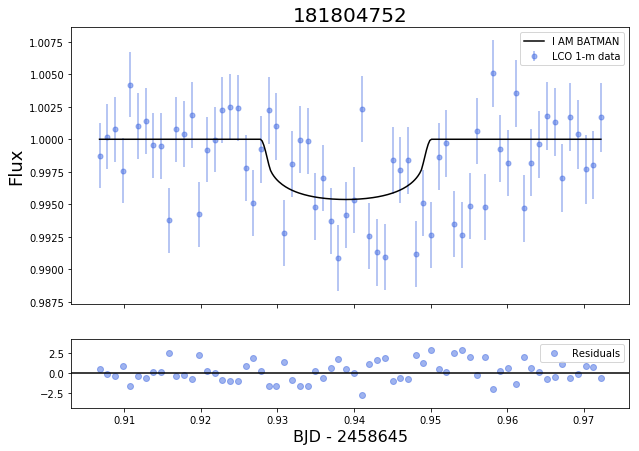

In [14]:
times = np.linspace(lc.time[0],lc.time[-1],300)
# This is a highres time array to be used when we plot the model

alert_model = BATMAN(t = times)
model_flux = BATMAN(t = lc.time)
residual = (model_flux-lc.flux)/lc.flux_err

f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                           figsize=(10,7),sharex=True)
a0.set_title(planet_name,fontsize=20)
a0.set_ylabel('Flux',fontsize=18)
a0.errorbar(lc.time,lc.flux,yerr=lc.flux_err,fmt='o',alpha=0.5,color='royalblue'
            ,markersize='5',label=observatory+' data')
a0.plot(times,alert_model,zorder=100,color='k',label='I AM BATMAN')
a0.legend()

a1.scatter(lc.time,residual,color='royalblue',alpha=0.5,label='Residuals')
a1.axhline(0,color='k')
a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
a1.legend()

plt.xlabel('BJD - '+str(offset),fontsize=16)
plt.savefig(str(planet_name)+'_prefit.pdf')

Next, we will define the **lnprob** function which will be used in the MCMC calculation. This function will also create a plot of the model results.

In [15]:
def lnprob(parameters, plot = False, extra_mods = False,
           Title = planet_name, Rp_best = 0, Rp_diff = 0,
           t0_best = 0, t0_diff = 0):
        
    # Pull out some model parameters
    rp, t_0 = parameters
    
    # First we want a model to perform the lnprob calculation with.
    model = BATMAN(Rp = rp, t0 = t_0, t = lc.time)
    
    residual = (model-lc.flux)/lc.flux_err
    
    # This is the model that will be plotted
    model_to_plot = BATMAN(Rp = rp, t0 = t_0, t = times)
    
    if plot:
        
        f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                                   figsize=(10,7),sharex=True)
        
        a0.set_title(Title,fontsize=20)
        a0.errorbar(lc.time,lc.flux,yerr=lc.flux_err,fmt='o',alpha=0.5,color='royalblue',
                    markersize='5',label=observatory+' data')
        a0.plot(times,model_to_plot,label='MCMC Model',color='k',zorder=100)
        #a0.plot(times,alert_model,label='Preliminary Parameters',color='purple',zorder=99)
        a0.set_ylabel('Normalized Flux',fontsize=18)

        a1.scatter(lc.time,residual,color='royalblue',alpha=0.5,label='Residuals')
        a1.axhline(0,color='k')
        a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
        
        if extra_mods:
            y1 = BATMAN(Rp=rp, t0 = t_0+t0_diff, t = times)
            y2 = BATMAN(Rp=rp, t0 = t_0-t0_diff, t = times)
            a0.fill_between(times,y1,y2,label='1-$\sigma$ Models',
                            alpha=0.5,color='red',zorder=100)
            y1 = BATMAN(Rp = rp+Rp_diff, t0 = t_0, t = times)
            y2 = BATMAN(Rp = rp-Rp_diff, t0 = t_0, t = times)
            a0.fill_between(times,y1,y2,alpha=0.5,color='red',zorder=100)
        
        a0.legend()
        a1.legend()
        plt.xlabel('BJD - '+str(offset),fontsize=16)
        plt.savefig(str(planet_name)+'_MCMCfit.pdf')
        plt.savefig(str(planet_name)+'_MCMCfit.png')
    
    # This is a Gaussian likelihood, for independent data points
    
    if (0.0 <= rp <= 1.0) and (times[0] <= t_0 <= times[-1] ):
        chisq = np.sum((lc.flux - model)**2/(lc.flux_err)**2)
        lnp = np.sum(1/np.sqrt(2*np.pi*(lc.flux_err))) - 0.5*chisq
    
        return lnp
    
    return -np.inf

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

465.0965922946069


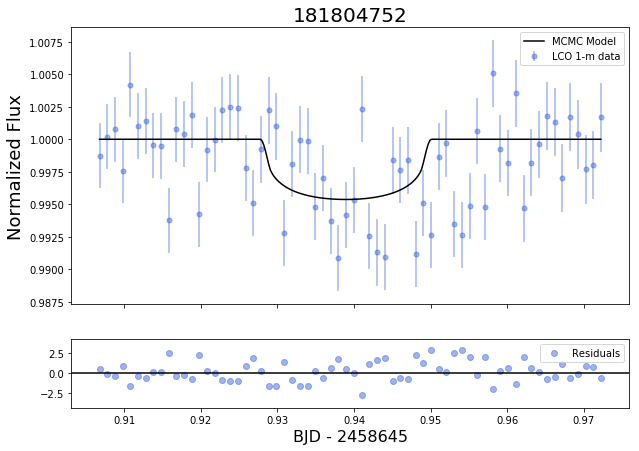

In [16]:
params = [planet_radius,expected_t0]
a = lnprob(params,plot=True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [17]:
# intialize some walkers
ndim, nwalkers, nsteps = 2, 100, 10000
burnin = int(0.2*nsteps)

# these are initial parameters
Rp_initial = np.random.uniform(rp_range[0], rp_range[1], nwalkers)
t0_initial = np.random.uniform(t0_range[0], t0_range[1], nwalkers)

p0 = np.transpose([Rp_initial, t0_initial])

In [18]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

We can inspect the distribution parameters from our MCMC by defining a function, **plot_chain**, which will show various visualizations of the results.

In [19]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    Rp, t0 = sampler.chain.T
    Rp_trimmed, t0_trimmed = sampler.chain.T[:, start:stop, :]

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(3,2)
    
    #Walker Plots
    
    ax_Rp = plt.subplot(gs[0,0])
    ax_Rp.plot(Rp.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    ax_t0 = plt.subplot(gs[0,1])
    ax_t0.plot(t0.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_t0.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_t0.set_ylabel('t0')
    
    #Histograms
    
    ax_Rphist = plt.subplot(gs[1,0])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=60)
    ax_Rphist.axvline(planet_radius,zorder=100,color='purple',label='Expected Value')
    ax_Rphist.set_xlabel('Rp')
    ax_Rphist.legend()
    
    ax_t0hist = plt.subplot(gs[1,1])
    ax_t0hist.hist(t0.flatten(),color='black',bins=60)
    ax_t0hist.axvline(expected_t0,zorder=100,color='purple',label='Expected Value')
    ax_t0hist.set_xlabel('t0')
    ax_t0hist.legend()
    
    #Scatter Plots
    
    ax_both = plt.subplot(gs[2,0])
    ax_both.scatter(t0_trimmed, Rp_trimmed, s=5, alpha=0.1)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Mid-Transit')
    ax_both.set_ylabel('Rp')

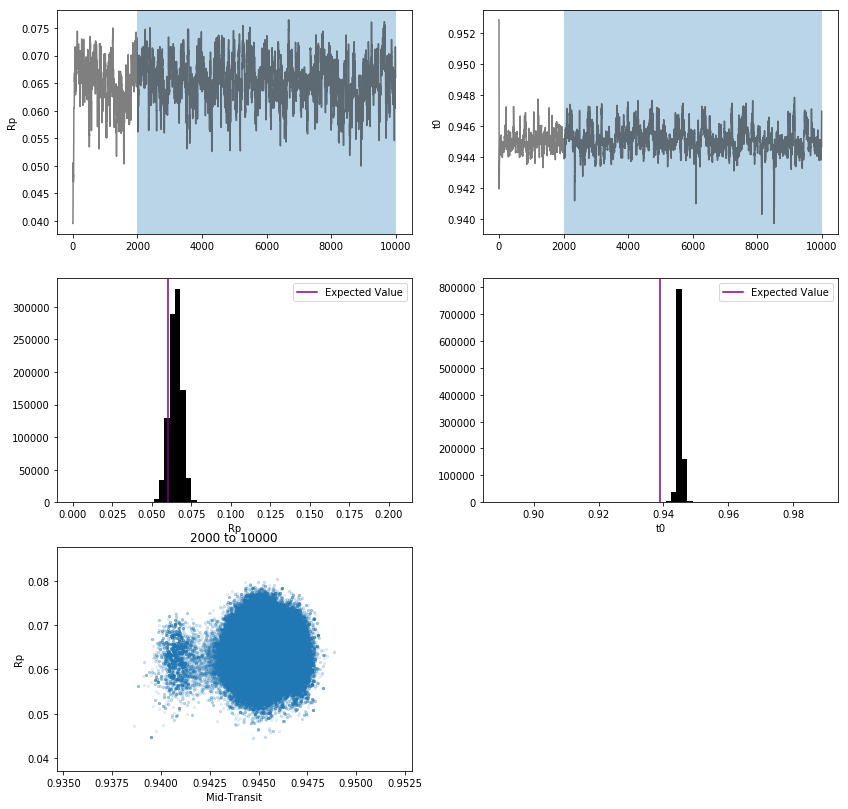

In [20]:
plot_chain(burnin,nsteps)

We want to extract the best-fit parameters as well as the 1-sigma uncertainty range:

In [34]:
Rp = sampler.flatchain[int(nsteps*nwalkers/2):,0]
t0 = sampler.flatchain[int(nsteps*nwalkers/2):,1]

sig1_Rp = np.percentile(Rp, [16., 50., 84.])
sig1_t0 = np.percentile(t0, [16., 50., 84.])

In [47]:
print('Rp/R*= {:.5f}'.format(sig1_Rp[1]),
      '+ {:.5f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.5f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168),'R_Earth')

print('Mid-Transit Time = {:.6f}'.format(sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print("Anticipated mid-transit time = {:.6f}".format(expected_t0))

Rp/R*= 0.06517 + 0.00372 - 0.00399
Rp = 1.067 + 0.061 - 0.065 R_Earth
Mid-Transit Time = 0.945052 + 0.000630 - 0.000550
Anticipated mid-transit time = 0.938936


Lastly, we extract the best-fit parameters and make a plot displaying those as well as the 1-sigma models as a shaded region:

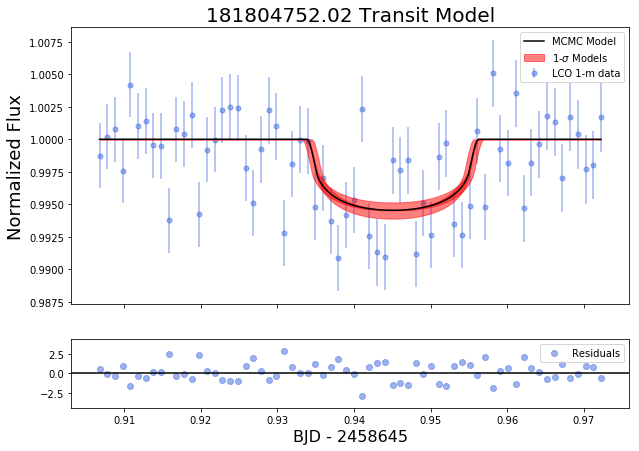

In [29]:
params = [sig1_Rp[1],sig1_t0[1]]

a = lnprob(params,plot=True,extra_mods=True,
           Title=str(planet_name)+'.02'+' Transit Model',
           Rp_best = sig1_Rp[1],Rp_diff =(sig1_Rp[2]-sig1_Rp[1]),
           t0_best = sig1_t0[1],t0_diff =(sig1_t0[2]-sig1_t0[1]))